#### **Problem 1**
Download daily Closing Index for the CSI 300 index from CSMAR’s China Stock Market Series/Stock Trading/Market Index table over 2006/1/1 to 2023/12/31.

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

target_index = pd.read_csv("TRD_Index.csv")
target_index = target_index[target_index["Indexcd"] == 300]
target_index.columns = ["code", "trade_date", "close_index"]
print(target_index)

       code  trade_date  close_index
21302   300  2006-01-04   941.428000
21303   300  2006-01-05   959.134000
21304   300  2006-01-06   970.032000
21305   300  2006-01-09   975.253000
21306   300  2006-01-10   978.154000
...     ...         ...          ...
25671   300  2023-12-25  3347.451000
25672   300  2023-12-26  3324.790000
25673   300  2023-12-27  3336.357000
25674   300  2023-12-28  3414.540000
25675   300  2023-12-29  3431.110000

[4374 rows x 3 columns]


a. Manually derive monthly CSI 300 index returns and provide summary statistics on mean, standard deviation, skewness and kurtosis for monthly CSI 300 index returns.

In [150]:
# Retain last record in each month and calculate return.
target_index["trade_date"] = pd.to_datetime(target_index["trade_date"]).dt.to_period("M")
target_index = target_index.drop_duplicates(subset = "trade_date", keep = "last")
target_index["return"] = target_index["close_index"].pct_change()
target_index = target_index.dropna(subset = "return")

# Statistics.
stats_summary = {
    "Mean": target_index["return"].mean(),
    "Std": target_index["return"].std(),
    "Skewness": stats.skew(target_index["return"]),
    "Kurtosis": stats.kurtosis(target_index["return"])
}
stats_df = pd.DataFrame.from_dict(stats_summary, orient = "index")
print(stats_df)

                0
Mean     0.009042
Std      0.081745
Skewness 0.018308
Kurtosis 1.393663


b. Plot a histogram for CSI 300 monthly returns.

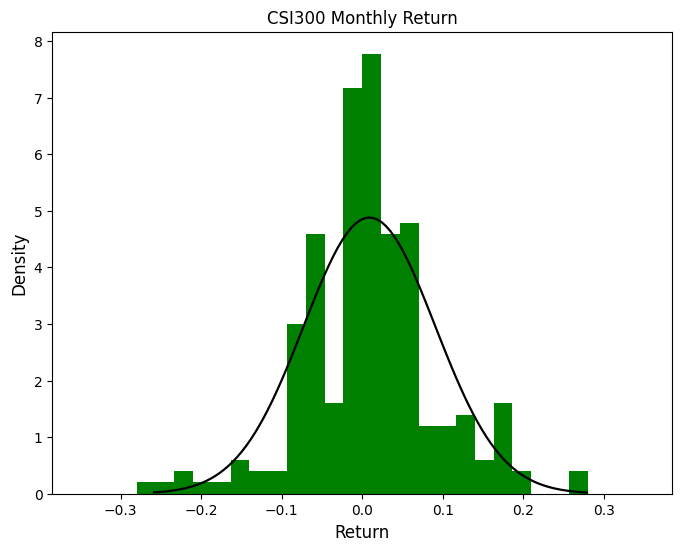

ShapiroResult(statistic=np.float64(0.9712842203281807), pvalue=np.float64(0.00022801795669057684))


In [151]:
plt.figure(figsize = (8, 6))
plt.hist(target_index["return"], bins = 30, range=(-0.35, 0.35), density = True, color = "green")

# Attach the normal distribution curve.
miu, sigma = stats_summary["Mean"], stats_summary["Std"]
x = np.linspace(target_index["return"].min(), target_index["return"].max(), 100)
plt.plot(x, stats.norm.pdf(x, miu, sigma), "k-", linewidth = 1.6)

plt.title("CSI300 Monthly Return", fontsize = 12)
plt.xlabel("Return", fontsize = 12)
plt.ylabel("Density", fontsize = 12)

plt.show()

# Conduct Shapiro-Wilk test.
print(stats.shapiro(target_index["return"]))

#### **Problem 2**
Since the seminal work of Jensen, Black, and Scholes(1972, hereafter BJS), there have been numerous empirical attempts to examine the relationship between asset risks and expected returns. In a simplified adaptation of BJS’s framework, Chen et al. (2019) apply this methodology to the Chinese stock market. Please carefully read through Chen et al. (2019) and complete the following tasks.

a. Download weekly Returns Without Cash Dividend Reinvested for all A-share mainboard stocks from China Stock Market Series/Stock Trading/Individual Stock Trading table from the first week of 2017 to the last week of 2022.

In [152]:
weekly1 = pd.read_csv("TRD_Week.csv")
weekly2 = pd.read_csv("TRD_Week1.csv")
weekly_return = pd.concat([weekly1, weekly2])

weekly_return.columns = ["code", "date", "return", "type"]
weekly_return = weekly_return[weekly_return["type"].isin([1, 4, 64])]
weekly_return = weekly_return.drop(columns = "type")
print(weekly_return)

          code     date    return
0            1  2017-01  0.003297
1            1  2017-02  0.003286
2            1  2017-03  0.006550
3            1  2017-04  0.011931
4            1  2017-05 -0.007503
...        ...      ...       ...
192896  873527  2022-49 -0.005513
192897  873527  2022-50 -0.024390
192898  873527  2022-51 -0.019318
192899  873527  2022-52 -0.067207
192900  873527  2022-53  0.000000

[889071 rows x 3 columns]


b. Calculate weekly market returns as the mean value of weekly returns of all mainboard stocks.

In [153]:
weekly_mean = weekly_return.groupby("date")["return"].mean().reset_index()
weekly_mean.columns = ["date", "mkt_return"]
print(weekly_mean)

        date  mkt_return
0    2017-01    0.018377
1    2017-02   -0.032801
2    2017-03   -0.015996
3    2017-04    0.018515
4    2017-05   -0.002261
..       ...         ...
303  2022-49    0.028340
304  2022-50    0.003581
305  2022-51   -0.014400
306  2022-52   -0.047955
307  2022-53    0.012777

[308 rows x 2 columns]


c. Load weekly risk-free return data.

In [154]:
weekly_free_return = pd.read_excel("weekly_risk_free_rate.xlsx")
weekly_free_return.columns = ["date", "free_return"]

# Transform date column to Y-W form.
weekly_free_return["date"] = pd.to_datetime(weekly_free_return["date"])
weekly_free_return["date"] = weekly_free_return["date"].dt.year.astype(str) + "-" \
    + ((weekly_free_return["date"].dt.dayofyear - 1) // 7 + 1).astype(str).str.zfill(2)

print(weekly_free_return)

        date  free_return
0    2017-01     0.000571
1    2017-02     0.000738
2    2017-03     0.000543
3    2017-04     0.000774
4    2017-05     0.000802
..       ...          ...
307  2022-48     0.000444
308  2022-49     0.000471
309  2022-50     0.000477
310  2022-51     0.000459
311  2022-52     0.000432

[312 rows x 2 columns]


d. Follow Section 4 in Chen et al. (2019) to replicate Table 2 and 3 with data obtained from (a) - (c), i.e., reproduce two tables with the original methology yet with different data.

**How to test CAPM?**

Given N stocks over time t ∈ {1, 2 ... T}, suppose we have $r_{i} - r_{f} = \alpha_{i} + \beta_{i} (r_{m} - r_{f}) + \epsilon_{i}$. For each stock i, estimate a $\hat{\beta}_i$ over t ∈ {1, 2 ... T-1}. Then estimate ${\alpha}_i$ with $\hat{\beta}_i$ at t = T. Combine all ${\alpha}_i$ and test whether ${\alpha}$ is significantly different from zero.

This approach fails because, 

1. Individual stocks can have idiosyncratic risks. This indicates that the mean independence assumption fail. Thus the ${\beta}$ estimation fails. 
2. If we want to test significance of ${\alpha}$ using $\mu / \sigma$, we need to make sure ${\alpha}_i$ are iid distributed. Since individual stocks may have cross-sectional dependence, this assumption fails.

What about construct portfolio stocks which have lower idiosyncratic risks?

**Caution: market risk exposure may be offset as well!** Thus we group individual stocks into portfolios based on pre-estimated ${\beta}$ which ensure each portfolio consists of stocks with similar market risk exposure. 

In [155]:
# Merge 3 dfs.
test_df = pd.merge(weekly_return, weekly_mean, how = "left", on = "date")
test_df = pd.merge(test_df, weekly_free_return, how = "left", on = "date")
test_df = test_df.dropna(subset = "free_return")
test_df["ri_rf"] = test_df["return"] - test_df["free_return"]
test_df["rm_rf"] = test_df["mkt_return"] - test_df["free_return"]

In [156]:
# Deal with period 1.
test_p1 = test_df[test_df["date"].str.startswith(("2017", "2018"))].copy()

def run_regression(group):
    X = group["rm_rf"]
    X = sm.add_constant(X)  
    y = group["ri_rf"]
    model = sm.OLS(y, X).fit()
    return pd.Series({"beta": model.params["rm_rf"]})

# Estimate βi for each stock i.
reg_results = test_p1.groupby("code").apply(run_regression, include_groups = False).reset_index()
test_df = pd.merge(test_df, reg_results, on = "code", how = "left")
test_df = test_df.dropna(subset = "beta")

In [157]:
# Deal with period 2.
test_p2 = test_df[test_df["date"].str.startswith(("2019", "2020"))].copy()
test_p2["portfolio"] = pd.qcut(test_p2["beta"], q = 10, labels = False) + 1

portfolio_p2 = test_p2.groupby(["date", "portfolio"])["return"].mean().reset_index()
portfolio_p2["mkt_return"] = portfolio_p2.groupby("date")["return"].transform("mean")
portfolio_p2 = pd.merge(portfolio_p2, weekly_free_return, on = "date", how = "left")
portfolio_p2["ri_rf"] = portfolio_p2["return"] - portfolio_p2["free_return"]
portfolio_p2["rm_rf"] = portfolio_p2["mkt_return"] - portfolio_p2["free_return"]

def run_portfolio_regression(group):
    X = group["rm_rf"]
    X = sm.add_constant(X)
    y = group["ri_rf"]
    model = sm.OLS(y, X).fit()
    return pd.Series({
        "alpha": model.params["const"],
        "alpha_t": model.tvalues["const"],
        "alpha_p": model.pvalues["const"],
        "beta": model.params["rm_rf"],
        "beta_t": model.tvalues["rm_rf"],
        "beta_p": model.pvalues["rm_rf"],
        "r_squared": model.rsquared
    })

_reg_results = portfolio_p2.groupby("portfolio").apply(run_portfolio_regression, include_groups = False).reset_index()

pd.set_option("display.float_format", lambda x: "%.6f" % x)
print(_reg_results.to_string(index = False))

 portfolio     alpha   alpha_t  alpha_p     beta    beta_t   beta_p  r_squared
         1 -0.001197 -1.706392 0.091039 0.779320 34.705154 0.000000   0.923339
         2  0.000210  0.356219 0.722427 0.876663 46.375668 0.000000   0.955569
         3  0.000112  0.278144 0.781476 0.910936 70.605064 0.000000   0.980335
         4  0.000961  2.186009 0.031148 0.938965 66.730242 0.000000   0.978036
         5  0.000007  0.018604 0.985194 1.009239 88.911805 0.000000   0.987508
         6  0.000293  0.889660 0.375784 1.044442 98.946766 0.000000   0.989889
         7 -0.000124 -0.275666 0.783373 1.047721 72.568432 0.000000   0.981365
         8  0.000022  0.047599 0.962130 1.099181 73.234682 0.000000   0.981696
         9  0.000312  0.549900 0.583614 1.139930 62.694376 0.000000   0.975190
        10 -0.000597 -0.943806 0.347544 1.153603 57.007136 0.000000   0.970148


In [ ]:
# Deal with period 3.
test_p3 = test_df[test_df["date"].str.startswith(("2021", "2022"))].copy()
test_p3["portfolio"] = pd.qcut(test_p3["beta"], q = 10, labels = False) + 1

portfolio_p3 = test_p3.groupby(["date", "portfolio"])["return"].mean().reset_index()
portfolio_p3 = pd.merge(portfolio_p3, weekly_free_return, on = "date", how = "left")
portfolio_p3["ri_rf"] = portfolio_p3["return"] - portfolio_p3["free_return"]

_portfolio_p3 = portfolio_p3.groupby("portfolio")["ri_rf"].mean().reset_index()
beta = _reg_results[["portfolio", "beta"]].copy()
_portfolio_p3 = pd.merge(_portfolio_p3, beta, how = "left", on = "portfolio")

X = _portfolio_p3["beta"]
X = sm.add_constant(X)
y = _portfolio_p3["ri_rf"]
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  ri_rf   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     10.32
Date:                Sun, 06 Apr 2025   Prob (F-statistic):             0.0124
Time:                        15:32:43   Log-Likelihood:                 66.311
No. Observations:                  10   AIC:                            -128.6
Df Residuals:                       8   BIC:                            -128.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.617      0.1

D:\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
